#### Specific Version's Packages Installation

In [ ]:
#!pip install -r requirements.txt

     |████████████████████████████████| 24.2 MB 2.6 MB/s 
     |████████████████████████████████| 13.1 MB 44.8 MB/s 
     |████████████████████████████████| 1.5 MB 31.1 MB/s 
     |████████████████████████████████| 17.3 MB 208 kB/s 
     |████████████████████████████████| 10.1 MB 29.7 MB/s 
     |████████████████████████████████| 5.6 MB 6.5 MB/s 
     |████████████████████████████████| 26.3 MB 2.7 MB/s 
     |████████████████████████████████| 6.7 MB 46.1 MB/s 
     |████████████████████████████████| 25.2 MB 2.1 MB/s 
     |████████████████████████████████| 208 kB 45.7 MB/s 
     |████████████████████████████████| 734.6 MB 17 kB/s 
     |████████████████████████████████| 10.2 MB 34.4 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 301 kB 65.2 MB/s 
     |████████████████████████████████| 3.5 MB 36.4 MB/s 
     |████████████████████████████████| 1.6 MB 48.0 MB/s 
     |████████████████████████████████| 308 kB 65.8 MB/s 
     |████████

#### Import Packages for use

In [ ]:
import os
import sys
from glob import glob
import copy
import warnings
import time

from pomegranate import *
import pickle
import optuna

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import librosa
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

from customGNB import *
from parser import *

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch import nn
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.nn import init

## Usefull functions

In [ ]:
# function that reads wav files
def read_wav(f):
    wav, _ = librosa.core.load(f, sr=None)
    return wav

In [ ]:
def dataparser(directory):

    # Parse relevant dataset info
    files = glob(os.path.join(directory, "*.wav"))
    fnames = np.array([f.split("/")[-1].split(".")[0] for f in files])

    map_digits = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9} # dictionary to many string to int

    digits = [] # list to append spoken digits
    speakers = [] # list to append speaker's id
    wavs = [] # list to append wavs files
    for f in fnames:
      digits.append(map_digits[''.join(i for i in f if not i.isdigit())]) # remove numeric digits
      speakers.append(int(''.join(c for c in f if c.isdigit()))) # keep only numeric digits
      wavs.append(read_wav('./digits/{}.wav'.format(f))) # read wav file

    _, Fs = librosa.core.load(files[0], sr=None) # find Fs from librosa

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))
    return wavs, np.array(speakers), np.array(digits)   # 'wavs' is list, because of the difference of the signal duration(mfccs matrix is W x 13)
                                                        # 'speakers' and 'digits' are np.arrays

We call the dataparser and store our data

In [ ]:
wavs, speakers, digits = dataparser('./digits')

Total wavs: 133. Fs = 16000 Hz


## Section 0 - MFCC Extraction

We declare a funcion for feature extraction

In [ ]:
def extract_features(wavs, w_sec, s_sec, n_mfcc=13, Fs=16000,):
    window = int(w_sec * Fs) # window to be used
    step = int(s_sec * Fs)  # step to be used

    mfcc_deltas=[]  # list to append deltas
    mfcc_delta2s=[] # list to append delta-deltas

    # Extract MFCCs for all wavs
    mfccs = [
        librosa.feature.mfcc(
            y=wav, sr=Fs, win_length=window, hop_length=step, n_mfcc=n_mfcc
        ).T #This is a array W x 13
        for wav in tqdm(wavs, desc="Extracting features...")
    ]

    for mfcc in mfccs:
        mfcc_deltas.append(librosa.feature.delta(mfcc)) # get delta for each mfcc
        mfcc_delta2s.append(librosa.feature.delta(mfcc, order=2)) # get delta-deltas for each mfcc

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return mfccs, mfcc_deltas, mfcc_delta2s  #These are lists, because of the difference of the signal duration(mfccs matrix is W x 13)

In [ ]:
# Parameters Initialization
w_sec = 0.025 #sec
s_sec = 0.01 #sec
n_mfcc = 13
Fs = 16000 #Hz
mfccs, mfcc_deltas, mfcc_delta2s = extract_features(wavs, w_sec, s_sec, n_mfcc = n_mfcc, Fs=Fs)

Extracting features...: 100%|██████████| 133/133 [00:02<00:00, 66.24it/s]


Feature extraction completed with 13 mfccs per frame


In [ ]:
print(mfccs[0].shape)

(87, 13)


## Section 1 - Features Histograms / Correlation Matices

a) MFCCs Histogramms

In [ ]:
def hist(mfccs, digit, subtitle):

    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    for mfcc, ax, utter in list(zip(mfccs, axes.flatten(), np.arange(mfccs.shape[0]))):
        n, bins, patches = ax.hist(x=mfcc, bins='auto', color='#0504aa',alpha=0.5, rwidth=0.85)
        ax.grid(axis='y', alpha=0.75)
        ax.set_xlabel('mfc coefficient values')
        ax.set_ylabel(' frequency ')
        ax.set_title(subtitle + f'of Utterance {utter} of digit {digit}')

        maxval = n.max()
        # Set a clean upper y-axis limit.
        ax.set_ylim(ymax=np.ceil(maxval / 10) * 10 if maxval % 10 else maxval + 10)
    fig.tight_layout()
    plt.show()

In [ ]:
print(type(mfccs[1][:2]))

<class 'numpy.ndarray'>


In [ ]:
n1 = 6
n2 = 9

# n1
indxs1 = np.where(digits==n1)[0]
mfccs_n1 = np.array([mfccs[indx][:2] for indx in indxs1]) #This is an array of arrays of (2 X 13)

# n2
indxs2 = np.where(digits==n2)[0]
mfccs_n2 = np.array([mfccs[indx][:2] for indx in indxs2]) #This is an array of arrays of (2 X 13)


In [ ]:
print(mfccs_n2.shape)

(15, 2, 13)


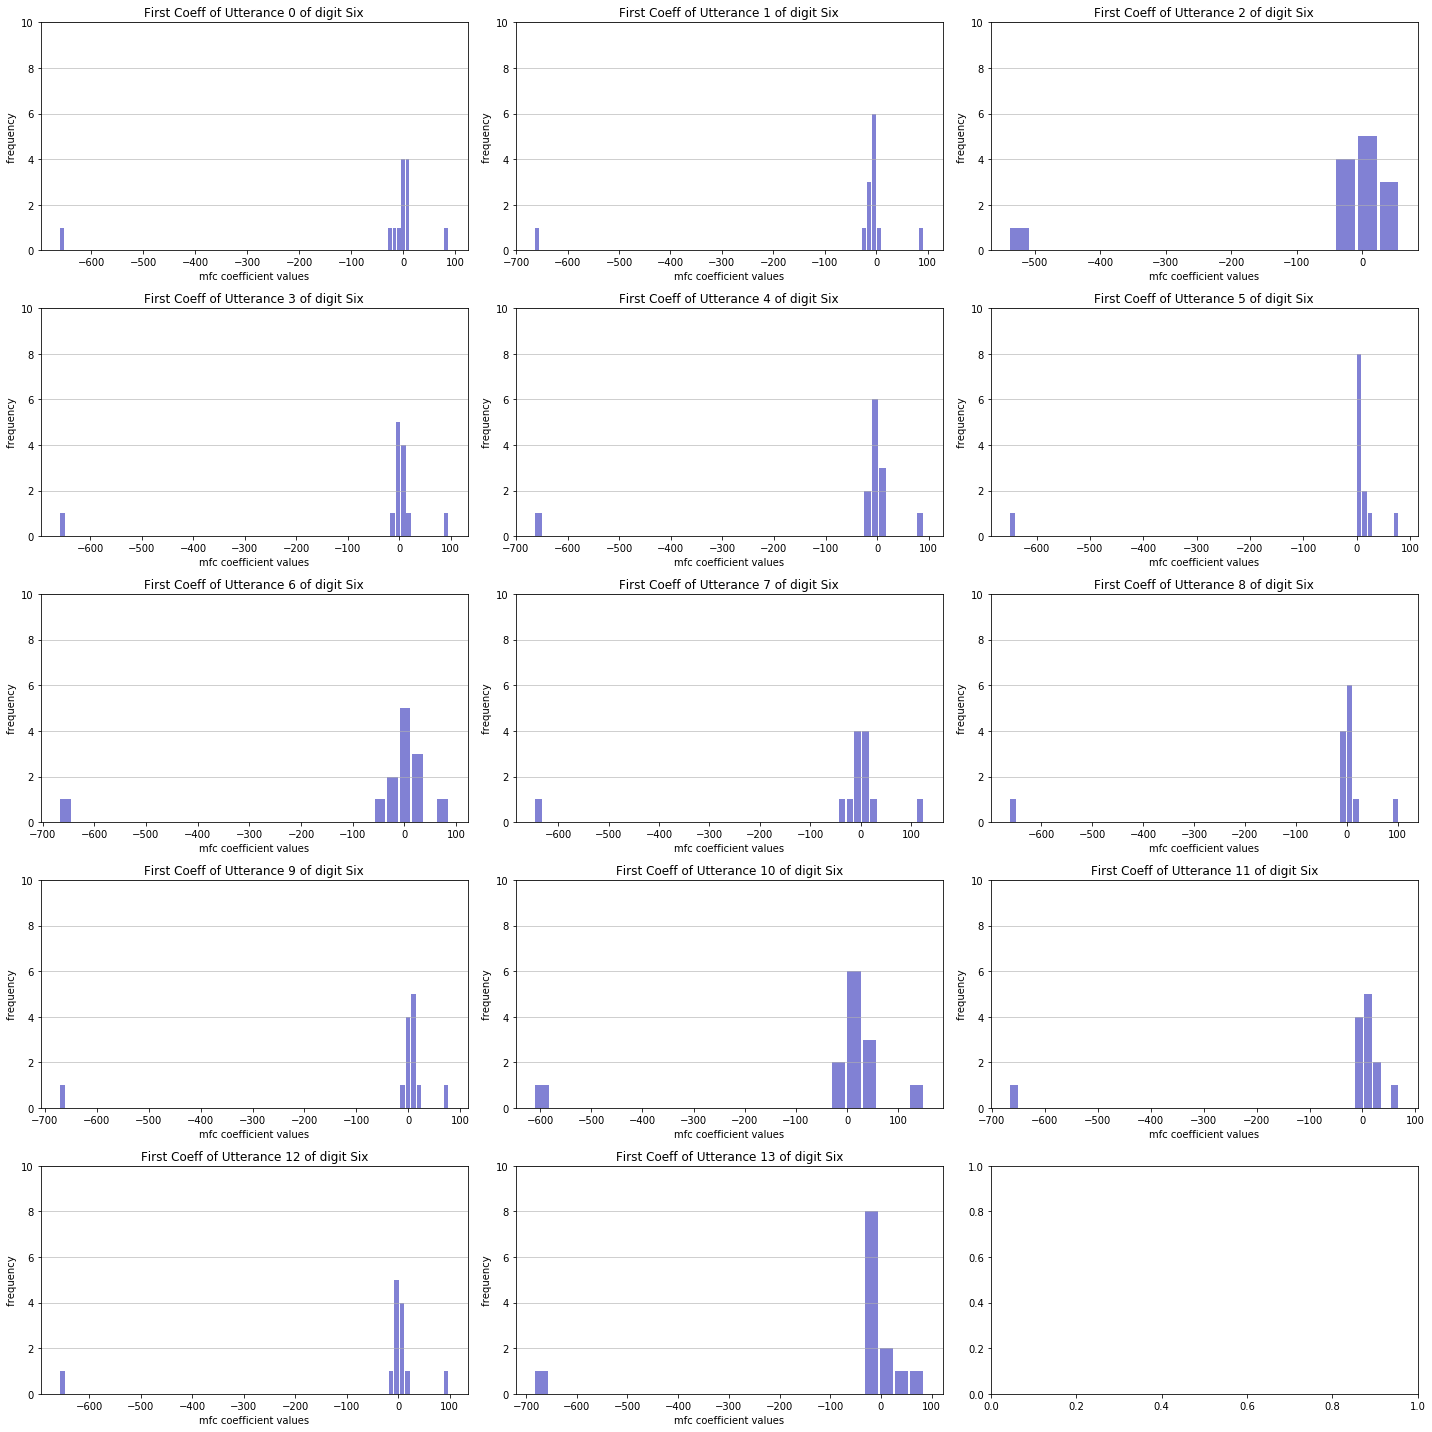

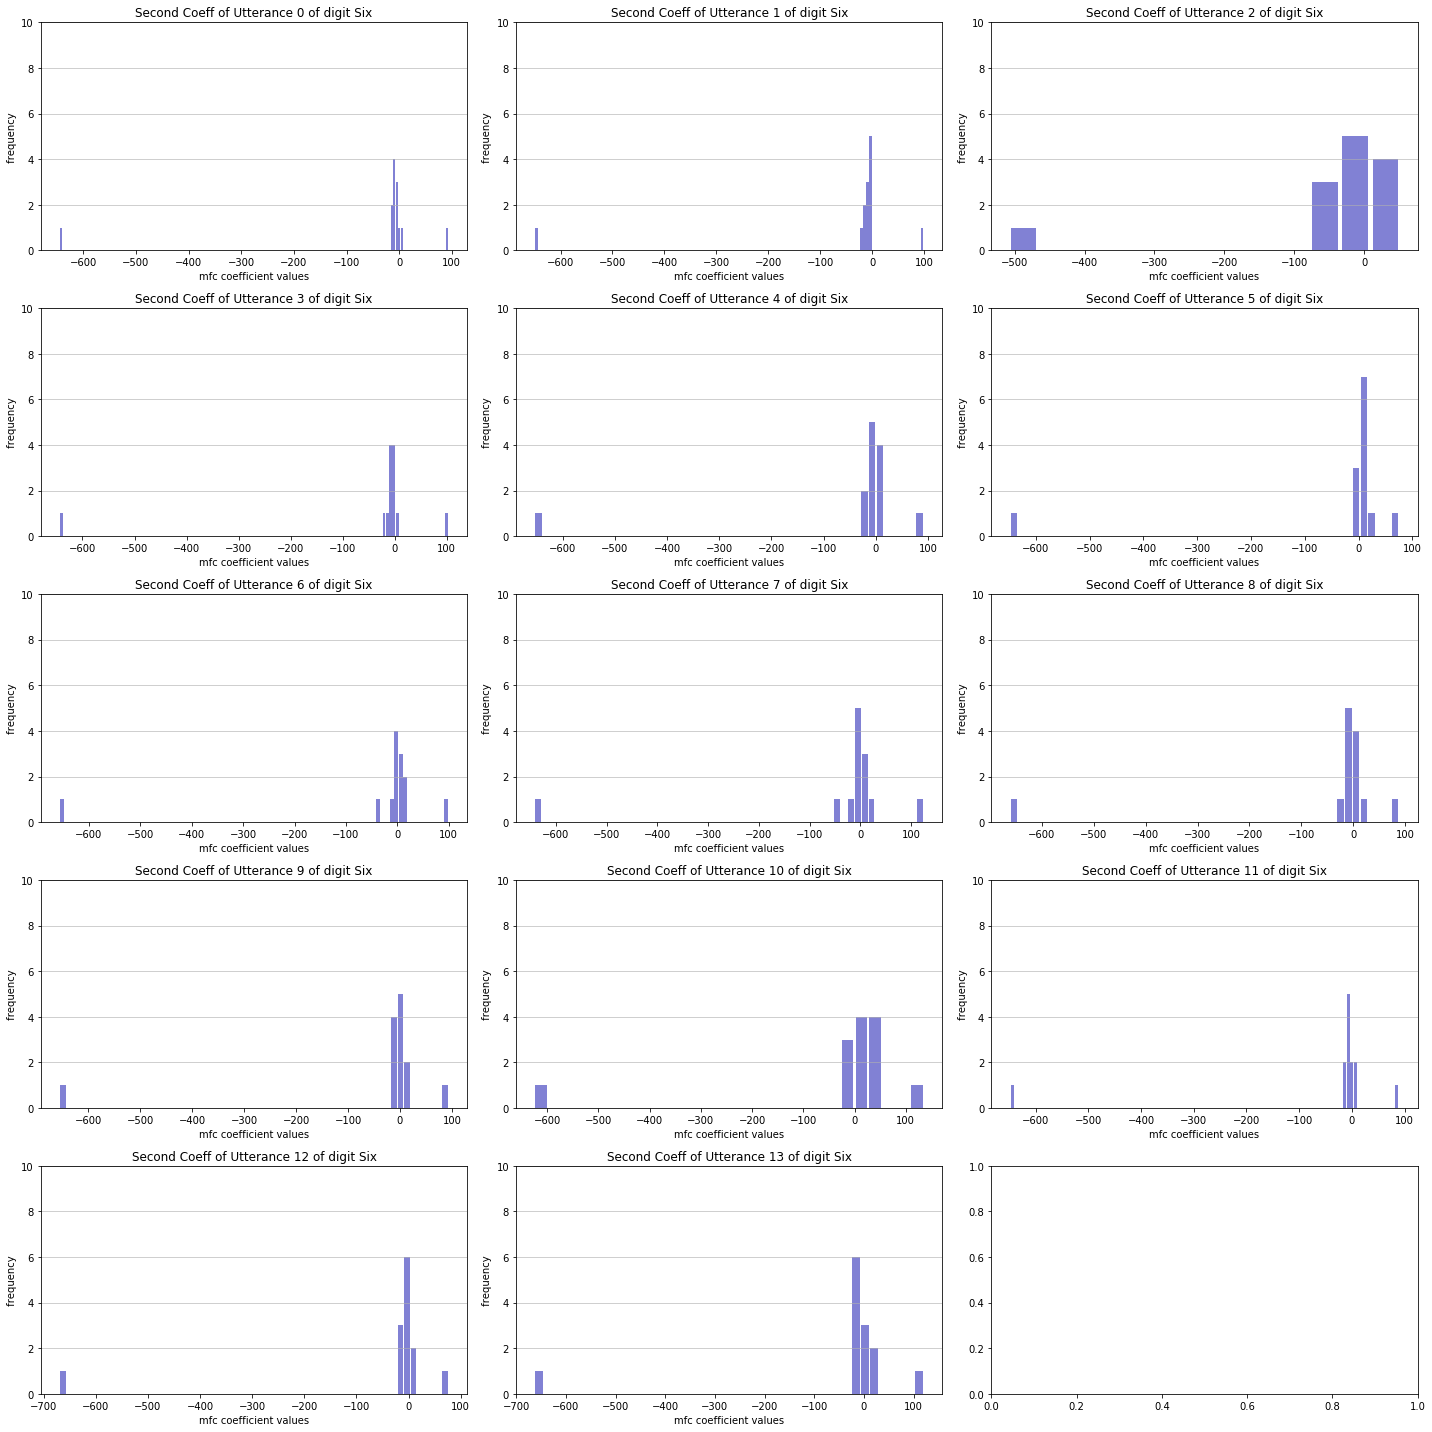

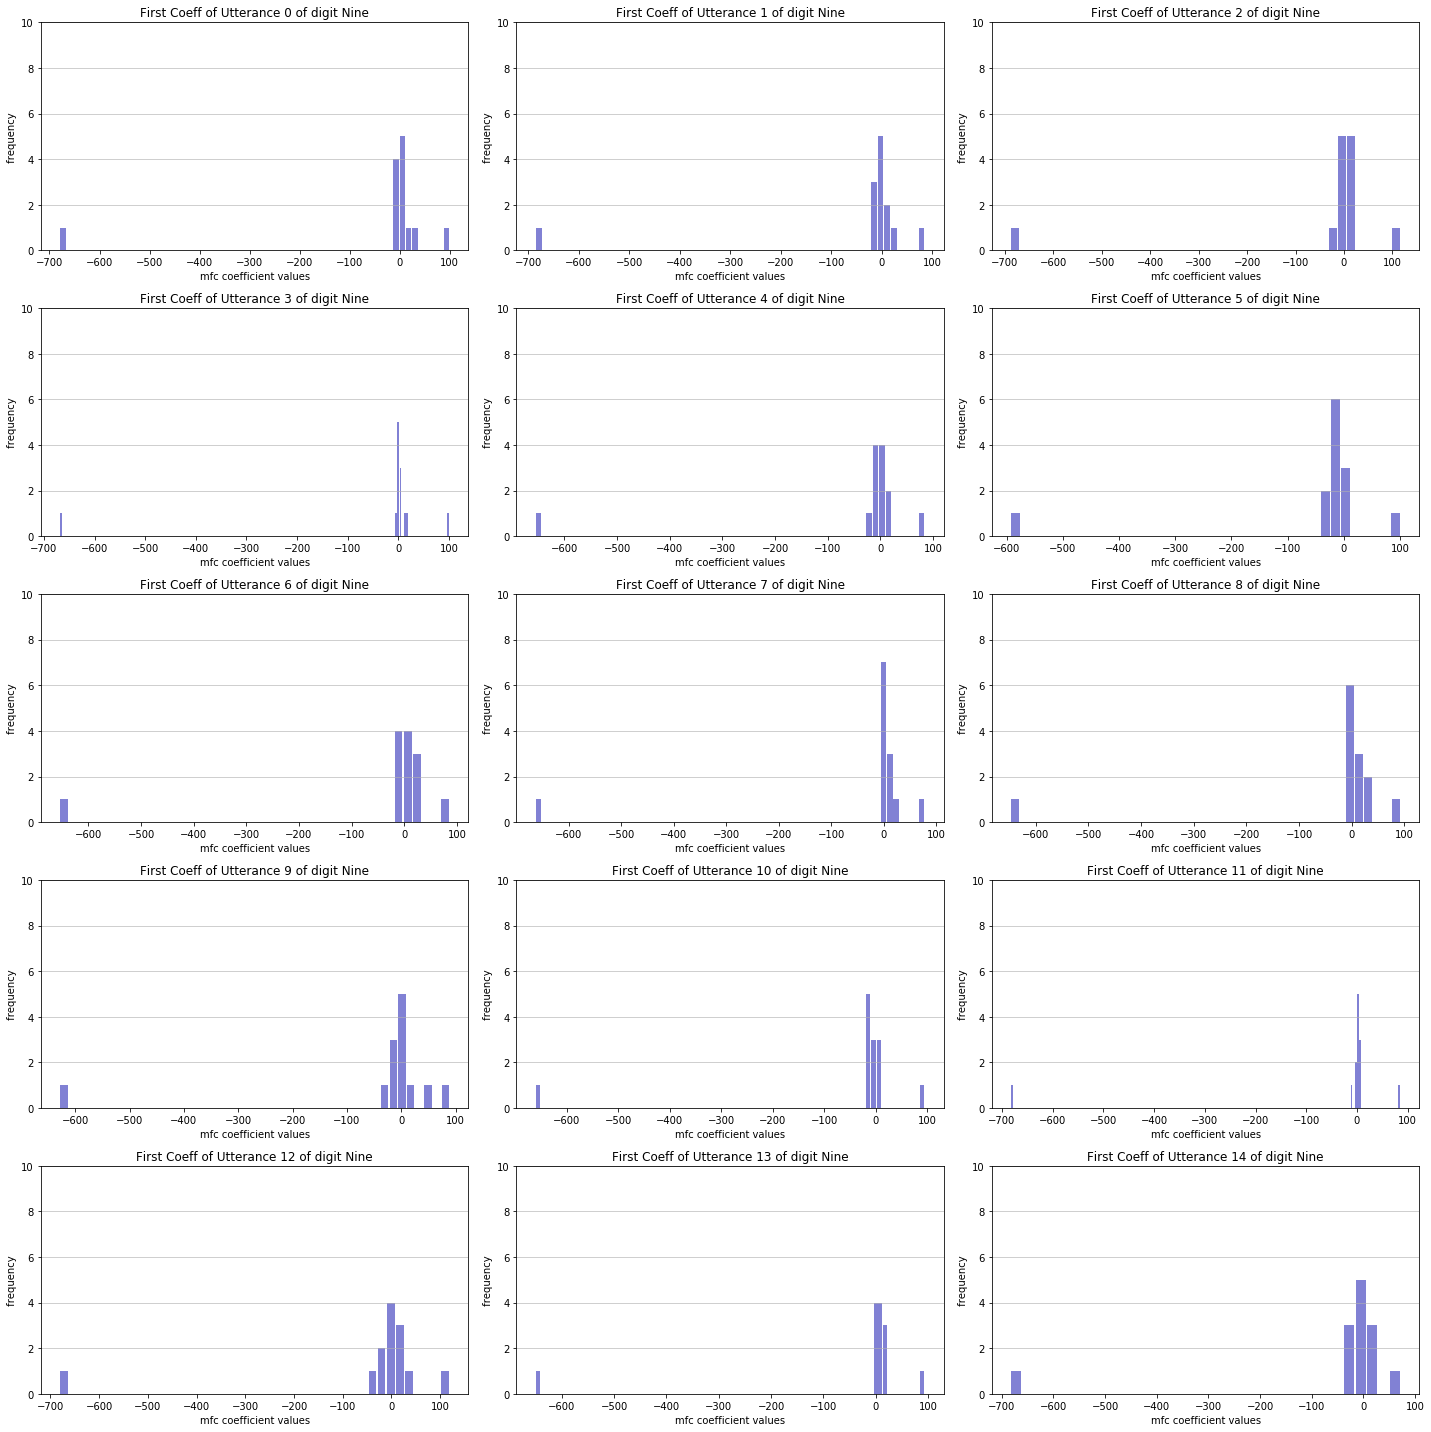

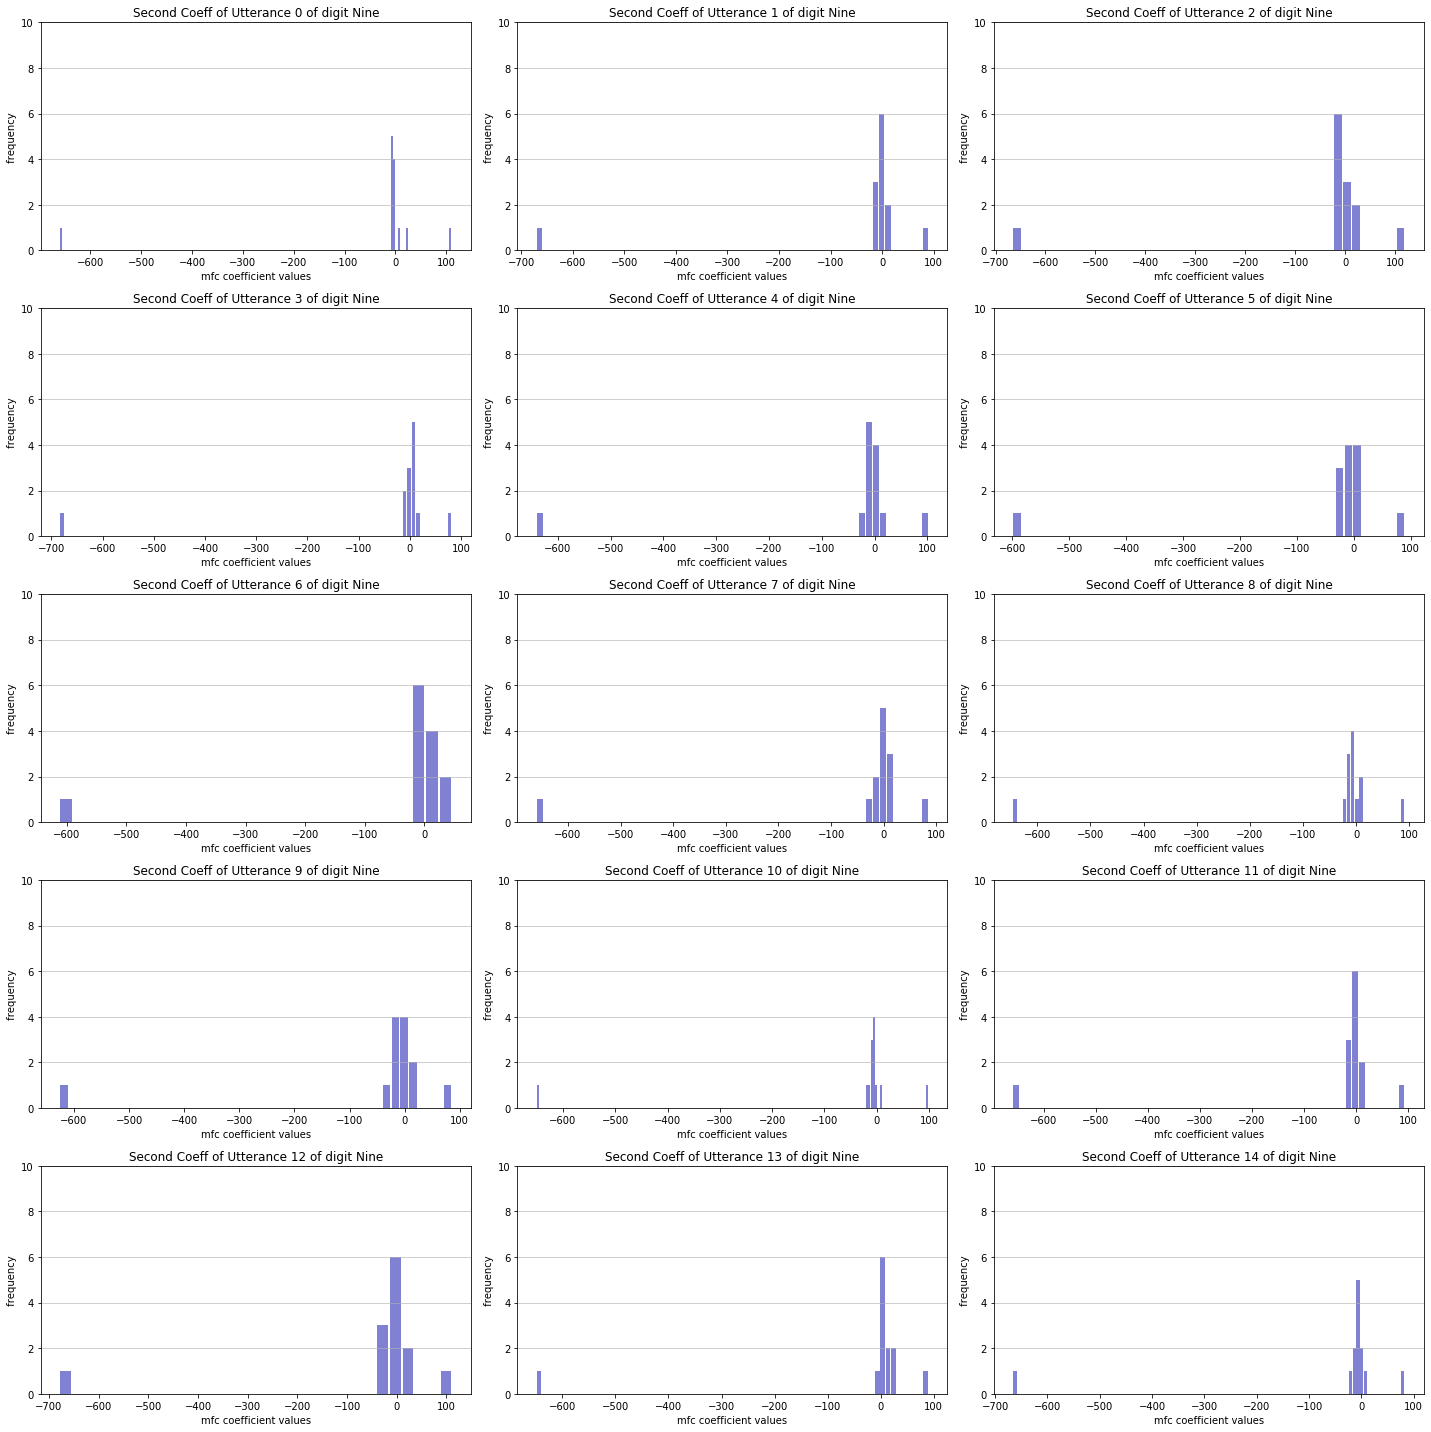

In [ ]:
hist(mfccs_n1[:,0], 'Six', 'First Coeff ')
print('\n')
hist(mfccs_n1[:,1], 'Six', 'Second Coeff ')
print('\n')
hist(mfccs_n2[:,0], 'Nine', 'First Coeff ')
print('\n')
hist(mfccs_n2[:,1], 'Nine', 'Second Coeff ')

b) MFSCs

In [ ]:
def extract_MFSCs(wavs, w_sec, s_sec, n_mels=13, Fs=16000,):
    # Extract MFCCs for all wavs
    window = int(w_sec * Fs)
    step = int(s_sec * Fs)

    mfscs = [
      librosa.feature.melspectrogram(
            y=wav, sr=Fs, win_length=window, hop_length=step,
            n_mels=n_mels
        ).T #This is an array of arrays of (W X 13)
        for wav in tqdm(wavs, desc="Extracting MFSCs...")

    ]

    print("Feature extraction completed with {} mfscs per frame".format(n_mels))

    return mfscs  #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)

In [ ]:
print(indxs1)

[  0   5  13  14  25  44  55  57  58  69  76  87 118 127]


In [ ]:
n1_subwavs = list([wavs[indx] for indx in indxs1][:2])
n2_subwavs = list([wavs[indx] for indx in indxs2][:2])
n_mels = 13 #== n_mels

In [ ]:
print(len(n1_subwavs))
print(n1_subwavs[0].shape)

2
(13822,)


In [ ]:
mfscs_n1 = extract_MFSCs(n1_subwavs, w_sec, s_sec, n_mels, Fs)  #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)
mfscs_n2 = extract_MFSCs(n2_subwavs, w_sec, s_sec, n_mels, Fs)

Extracting MFSCs...: 100%|██████████| 2/2 [00:00<00:00, 73.05it/s]

Feature extraction completed with 13 mfscs per frame
Feature extraction completed with 13 mfscs per frame


In [ ]:
print(len(mfscs_n1))
print(mfscs_n1[0].shape)

2
(87, 13)


### MFCCS Correlation Matrix

For N1 = 6

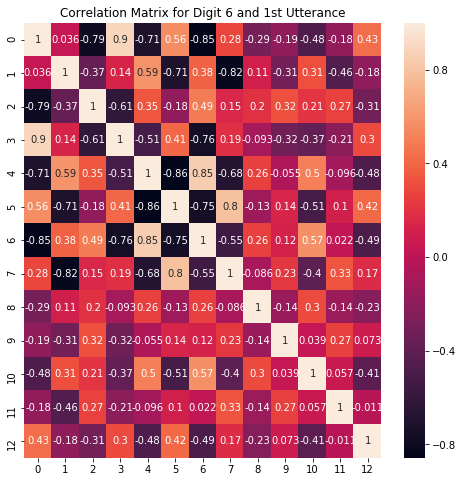

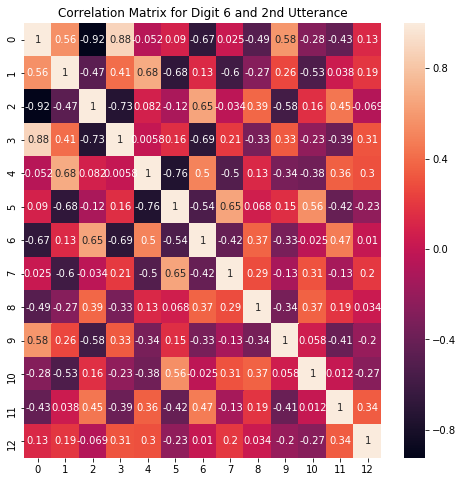

In [ ]:
# First Utterance
mfccs_n1 = [mfccs[indx] for indx in indxs1[:2]] #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)

n1_df_1 = pd.DataFrame(mfccs_n1[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 1st Utterance')
sns.heatmap(n1_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n1_df_2 = pd.DataFrame(mfccs_n1[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 2nd Utterance')
ax = sns.heatmap(n1_df_2.corr(), annot = True)
plt.show()

For N2 = 9

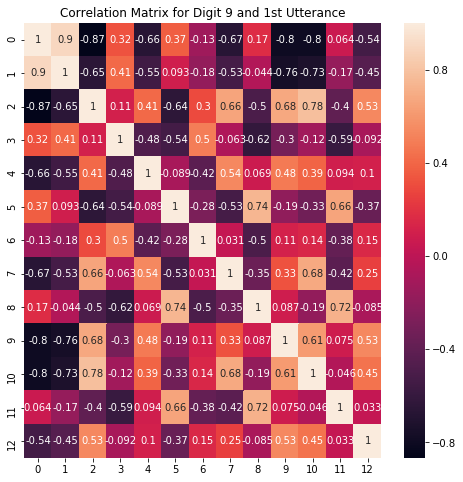

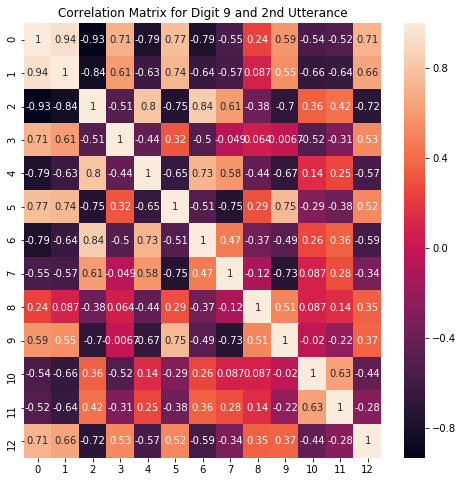

In [ ]:
# First Utterance
mfccs_n2 = [mfccs[indx] for indx in indxs2][:2] #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)

n2_df_1 = pd.DataFrame(mfccs_n2[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 1st Utterance')
sns.heatmap(n2_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n2_df_2 = pd.DataFrame(mfccs_n2[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 2nd Utterance')
ax = sns.heatmap(n2_df_2.corr(), annot = True)
plt.show()


### MFSCS Correlation Matrix

For N1 = 6

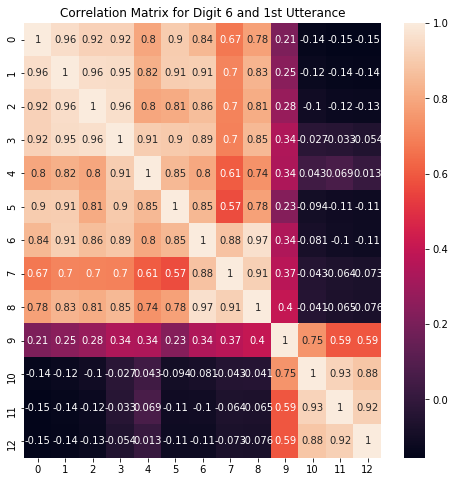

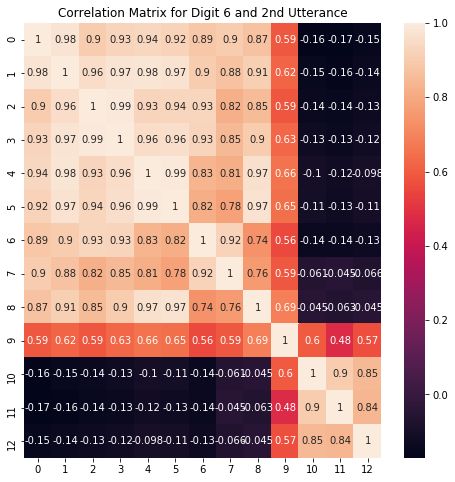

In [ ]:
# First Utterance
n1_df_1 = pd.DataFrame(mfscs_n1[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 1st Utterance')
sns.heatmap(n1_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n1_df_2 = pd.DataFrame(mfscs_n1[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 2nd Utterance')
ax = sns.heatmap(n1_df_2.corr(), annot = True)
plt.show()

For N2 = 9

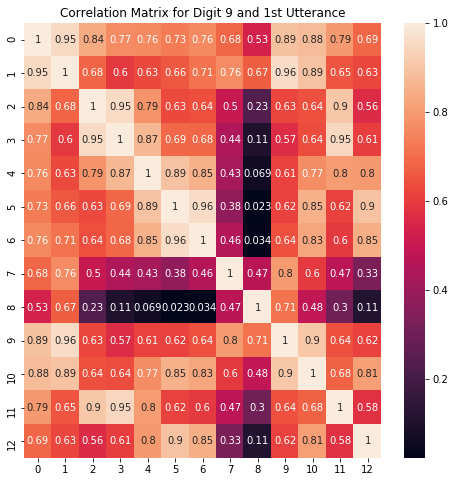

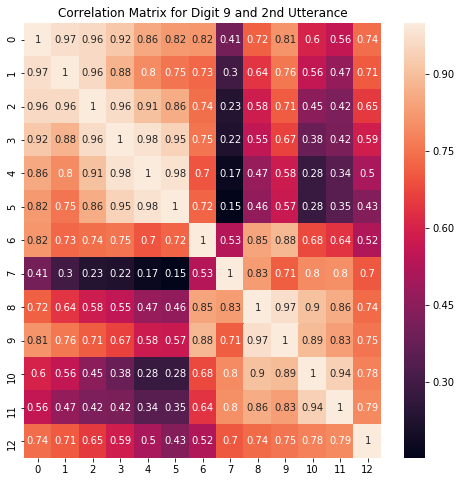

In [ ]:
# First Utterance
n2_df_1 = pd.DataFrame(mfscs_n2[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 1st Utterance')
sns.heatmap(n2_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n2_df_2 = pd.DataFrame(mfscs_n2[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 2nd Utterance')
ax = sns.heatmap(n2_df_2.corr(), annot = True)
plt.show()


## Section 2 - Data Dimensionality Reduction

In [ ]:
means = np.zeros((133, 39))
stds = np.zeros((133, 39))
for i in range (len(mfccs)):
  sample = np.concatenate((mfccs[i],mfcc_deltas[i],mfcc_delta2s[i]),axis=1) # (X,39), where X:unkonw
  mean = np.mean(sample,axis=0)
  std = np.std(sample,axis=0)
  means[i] = mean
  stds[i] = std


print(means.shape)#(133,39)
print(stds.shape) #(133,39)

(133, 39)
(133, 39)


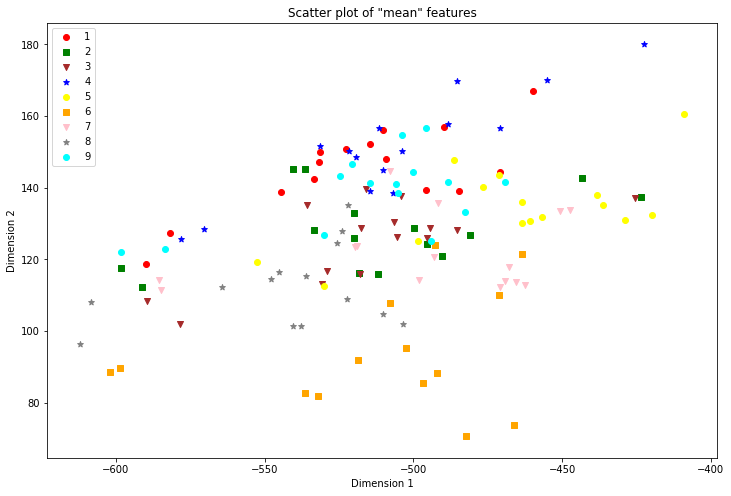

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  mean = np.array([means[indx] for indx in indxs])

  plt.scatter(mean[:, 0], mean[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "mean" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

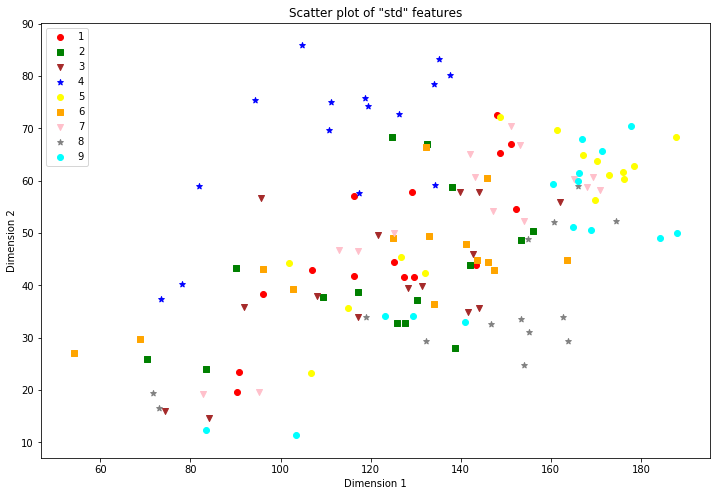

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  std = np.array([stds[indx] for indx in indxs])

  plt.scatter(std[:, 0], std[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "std" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### 2D PCA

In [ ]:
pca_mean = PCA(n_components=2)
pca_std = PCA(n_components=2)

_means = pca_mean.fit_transform(means)
_stds = pca_std.fit_transform(stds)

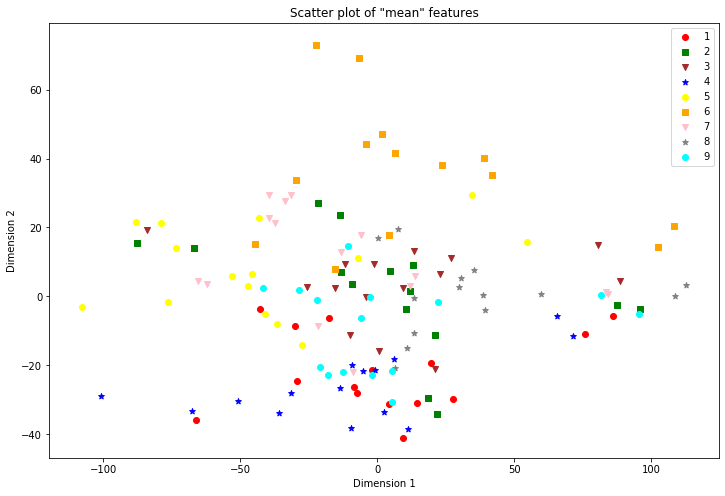

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _mean = np.array([_means[indx] for indx in indxs])

  plt.scatter(_mean[:, 0], _mean[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "mean" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

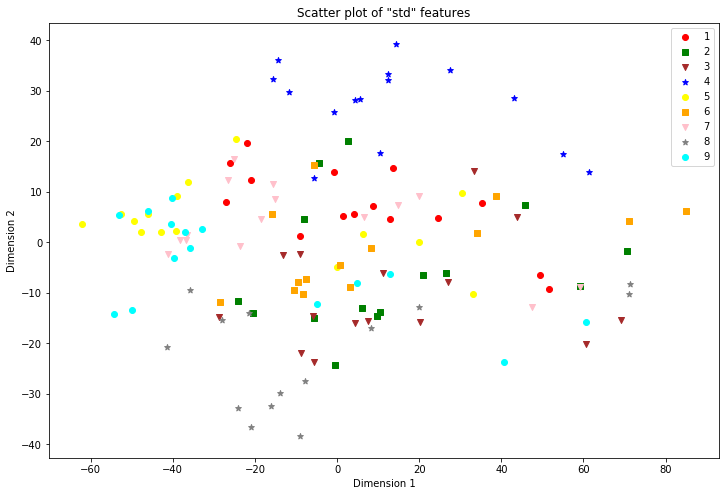

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _std = np.array([_stds[indx] for indx in indxs])

  plt.scatter(_std[:, 0], _std[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "std" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
print(pca_mean.explained_variance_ratio_)
print(pca_std.explained_variance_ratio_)

[0.66979977 0.14992746]
[0.69178909 0.15685564]


### 3D PCA

In [ ]:
pca_mean = PCA(n_components=3)
pca_std = PCA(n_components=3)

_means3 = pca_mean.fit_transform(means)
_stds3 = pca_std.fit_transform(stds)

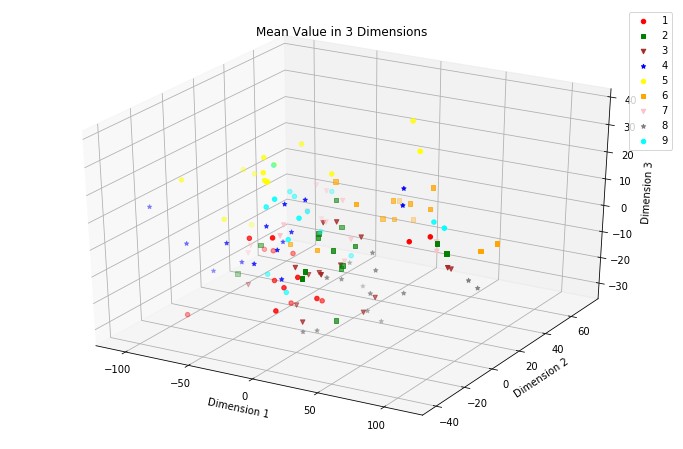

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']


for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _mean3 = np.array([_means3[indx] for indx in indxs])

  ax.scatter(_mean3[:, 0], _mean3[:, 1], _mean3[:, 2], c=color, marker=marker, label=digit)

plt.legend(loc='best')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Mean Value in 3 Dimensions')
plt.show()

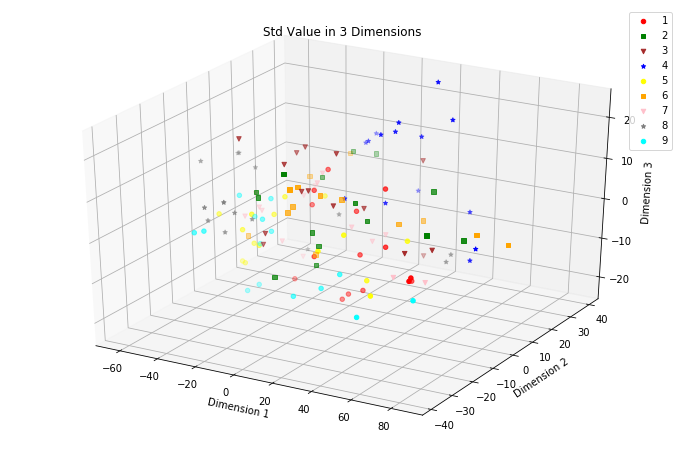

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']


for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _std3 = np.array([_stds3[indx] for indx in indxs])

  ax.scatter(_std3[:, 0], _std3[:, 1], _std3[:, 2], c=color, marker=marker, label=digit)

plt.legend(loc='best')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Std Value in 3 Dimensions')
plt.show()

In [ ]:
print(pca_mean.explained_variance_ratio_)
print(pca_std.explained_variance_ratio_)

[0.66979977 0.14992746 0.06334463]
[0.69178909 0.15685564 0.06599284]


## Section 3 - Baselines for Digit Classification

In [ ]:
def evaluate_clasifier(clf, X_train, y_train, X_test, y_test, folds=10):
    clf_clone = sklearn.base.clone(clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)  # calculate accuracy
    f1 = f1_score(y_test, y_pred, average='macro')  # calculate f1-score
    cross_val_acc = cross_val_score(clf_clone, X_train, y_train, cv=KFold(n_splits=folds), scoring="accuracy")  # calculate k-fold-cross-validation accuracy score
    cross_val_f1 = cross_val_score(clf_clone, X_train, y_train, cv=KFold(n_splits=folds), scoring="f1_macro")  # calculate k-fold-cross-validation f1 score
    return acc, f1, cross_val_acc, cross_val_f1


def Classifiers_evaluation(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()]):
  warnings.filterwarnings('ignore') # ignore warning messages
  scores_default = {}
  for clf in clfs:
      s1, s2, s3, s4 = evaluate_clasifier(clf, X_train, y_train, X_test, y_test, folds=10)
      scores_default[str(clf).split('(')[0]] = [s1, s2, np.mean(s3), np.std(s3), np.mean(s4), np.std(s4)]
  return scores_default


def display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()]):
  scores_default = Classifiers_evaluation(X_train, y_train, X_test, y_test, clfs)

  columns_labels = ['Classifier', 'Accuracy', 'F1-Score', '10-Fold Cross-Validation-Accuracy-Score', '10-Fold Cross-Validation-F1-Score']

  clfs_names = [str(clfs[0]).split('(')[0], str(clfs[1]).split('(')[0], str(clfs[2]).split('(')[0], str(clfs[3]).split('(')[0], str(clfs[4]).split('(')[0]]

  acc = [scores_default[clfs_names[0]][0], scores_default[clfs_names[1]][0], scores_default[clfs_names[2]][0], scores_default[clfs_names[3]][0], scores_default[clfs_names[4]][0]]

  f1 = [scores_default[clfs_names[0]][1], scores_default[clfs_names[1]][1], scores_default[clfs_names[2]][1], scores_default[clfs_names[3]][1], scores_default[clfs_names[4]][1]]

  cross_val_acc_means = [scores_default[clfs_names[0]][2], scores_default[clfs_names[1]][2], scores_default[clfs_names[2]][2], scores_default[clfs_names[3]][2], scores_default[clfs_names[4]][2]]
  cross_val_acc_stds = [scores_default[clfs_names[0]][3], scores_default[clfs_names[1]][3], scores_default[clfs_names[2]][3], scores_default[clfs_names[3]][3], scores_default[clfs_names[4]][3]]

  cross_val_f1_means = [scores_default[clfs_names[0]][4], scores_default[clfs_names[1]][4], scores_default[clfs_names[2]][4], scores_default[clfs_names[3]][4], scores_default[clfs_names[4]][4]]
  cross_val_f1_stds = [scores_default[clfs_names[0]][5], scores_default[clfs_names[1]][5], scores_default[clfs_names[2]][5], scores_default[clfs_names[3]][5], scores_default[clfs_names[4]][5]]
  cross_val_acc = []
  cross_val_f1 = []
  for i in range(5):
      cross_val_acc.append(str(str(cross_val_acc_means[i]) + ' +- ' + str(cross_val_acc_stds[i])))
      cross_val_f1.append(str(str(cross_val_f1_means[i]) + ' +- ' + str(cross_val_f1_stds[i])))

  values = zip(clfs_names, acc, f1, cross_val_acc, cross_val_f1)

  cm = sns.light_palette("pink", as_cmap=True)

  df1 = pd.DataFrame(values, columns=columns_labels)
  pd.options.display.float_format = "{:.3f}".format

  df1.style.set_caption("Scores of Classifiers")\
      .background_gradient(cmap=cm)

  display(df1)

*   1st Implementation [Vertical Stacking] -- X_data : (266x39)

In [ ]:
# create dataset
X_data = StandardScaler().fit_transform(np.concatenate((means,stds)))
y_data = np.concatenate((digits,digits))
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (266, 39)
Train-set shape: (186, 39), (186,)
Test-set shapes: (80, 39), (80,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.113,0.022,0.11286549707602338 +- 0.07721955948652193,0.023370626692995115 +- 0.015181728193252898
1,GaussianNB,0.263,0.269,0.26315789473684215 +- 0.1214841026474671,0.22150412858746193 +- 0.14249868433095167
2,DummyClassifier,0.100,0.091,0.09707602339181286 +- 0.0633606233019034,0.10763668430335098 +- 0.06353584861017249
3,KNeighborsClassifier,0.525,0.532,0.4681286549707602 +- 0.12317856632191217,0.42830236892736895 +- 0.13595243038418497
4,LogisticRegression,0.537,0.510,0.5695906432748539 +- 0.1288130342160044,0.5084766313932981 +- 0.12943525879601242


*   2nd Implementation [Vertical Stacking with PCA] -- X_data : (266x5)

In [ ]:
X_data = PCA(n_components=5).fit_transform(X_data)
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (266, 5)
Train-set shape: (186, 5), (186,)
Test-set shapes: (80, 5), (80,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.125,0.025,0.1067251461988304 +- 0.06207169167853321,0.024041070152953124 +- 0.01256968201675425
1,GaussianNB,0.400,0.343,0.3669590643274853 +- 0.1433121445682572,0.3193455387205387 +- 0.13716478215123962
2,DummyClassifier,0.100,0.086,0.14619883040935672 +- 0.08154697648487295,0.07813161375661377 +- 0.05597987298266959
3,KNeighborsClassifier,0.562,0.535,0.35058479532163744 +- 0.08536259132794455,0.3007440476190476 +- 0.06094083314437344
4,LogisticRegression,0.438,0.374,0.2903508771929824 +- 0.10427615565218107,0.24728678508440413 +- 0.09763618191056377


*   3rd Implementation [Horizontal Stacking] -- X_data : (133x78)

In [ ]:
# create dataset
X_data = StandardScaler().fit_transform(np.concatenate((means,stds),axis=-1))
y_data = digits
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (133, 78)
Train-set shape: (93, 78), (93,)
Test-set shapes: (40, 78), (40,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.100,0.020,0.12 +- 0.10515127257174203,0.03179220779220779 +- 0.026666429132579005
1,GaussianNB,0.675,0.714,0.6366666666666666 +- 0.17199267856941317,0.5495767195767195 +- 0.18439275655656848
2,DummyClassifier,0.125,0.121,0.07555555555555556 +- 0.08603760303380417,0.08176587301587303 +- 0.06902198313094747
3,KNeighborsClassifier,0.450,0.501,0.5411111111111111 +- 0.22487582307235504,0.47863888888888895 +- 0.23728927746513198
4,LogisticRegression,0.750,0.742,0.8066666666666669 +- 0.10578337987032806,0.7292526455026456 +- 0.1571155258385358


*   4th Implementation [Horizontal Stacking with PCA] -- X_data : (133x5)

In [ ]:
X_data = PCA(n_components=5).fit_transform(X_data)
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (133, 5)
Train-set shape: (93, 5), (93,)
Test-set shapes: (40, 5), (40,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.175,0.037,0.08666666666666667 +- 0.06607141665474892,0.024448051948051948 +- 0.020673344192418387
1,GaussianNB,0.500,0.457,0.43888888888888883 +- 0.1195929309608326,0.3268915343915344 +- 0.10056975037931645
2,DummyClassifier,0.075,0.086,0.09777777777777777 +- 0.09213516640723501,0.11488756613756612 +- 0.0641519149030727
3,KNeighborsClassifier,0.475,0.458,0.48 +- 0.1468853588414288,0.3449404761904762 +- 0.1192739663685583
4,LogisticRegression,0.375,0.345,0.5133333333333334 +- 0.11995884067791802,0.3807883597883598 +- 0.10382999834494563


*   5th Implementation [Extra Feautures / Zero Crossing Rate] -- X_data : (266x40)

In [ ]:
# Add a new feature to data

means_new = np.zeros((133, 40))
stds_new = np.zeros((133, 40))

for i in range (len(mfccs)):
  zcrs = librosa.feature.zero_crossing_rate(wavs[i],frame_length=400, hop_length=160)
  sample = np.concatenate((mfccs[i],mfcc_deltas[i],mfcc_delta2s[i],zcrs.T),axis=1) # (X,40), where X:unkonw
  mean = np.mean(sample,axis=0)
  std = np.std(sample,axis=0)
  means_new[i] = mean
  stds_new[i] = std

print(means_new.shape) #(133,40)
print(stds_new.shape) #(133,40)

(133, 40)
(133, 40)


In [ ]:
# create dataset
X_data = StandardScaler().fit_transform(np.concatenate((means_new,stds_new)))
y_data = np.concatenate((digits,digits))
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (266, 40)
Train-set shape: (186, 40), (186,)
Test-set shapes: (80, 40), (80,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.087,0.018,0.12339181286549708 +- 0.05895711420411021,0.02578787729408847 +- 0.01223728146872295
1,GaussianNB,0.350,0.341,0.31695906432748533 +- 0.08168525216540756,0.2781740944240944 +- 0.09894478135645647
2,DummyClassifier,0.113,0.108,0.12280701754385966 +- 0.05692374951442042,0.09396825396825395 +- 0.05162592503390623
3,KNeighborsClassifier,0.562,0.567,0.4619883040935672 +- 0.09063384218039473,0.3763403880070547 +- 0.06920621268371564
4,LogisticRegression,0.600,0.580,0.547953216374269 +- 0.09817945419251159,0.48731470579684866 +- 0.11413070805960311
